In [88]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
from scipy.signal import savgol_filter
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("talk")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [20]:
# Import csv file
df_csv = pd.read_csv(f'{homedir}/data/raw/EA_SO2_sulfate/O_Sulfate_isotopes.csv')
df_csv = df_csv.sort_values('Real_depth_cm')
#See dataframe
df_csv.head()

,ID,Core,Depth,d18O,d18O_sd,Real_depth_cm,Measurement
18,58,GC04,10,8.732701,0.254107,16.0,Oxygen
0,19,GC02,15,8.190571,0.129726,18.5,Oxygen
1,23,GC02,21,8.238678,0.317521,24.5,Oxygen
19,78,GC04,20,9.048273,0.151675,26.0,Oxygen
20,79,GC04,25,8.983339,0.098331,31.0,Oxygen


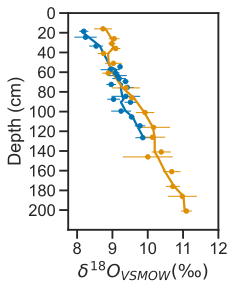

In [89]:
# Make plot just for oxygen
#Filter by sulfate
df_oxygen= df_csv[(df_csv.Measurement == 'Oxygen')]
# Group data by core
oxygen_grouped = df_oxygen.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(oxygen_grouped):
    # Get Unique core labels
    color_labels = sort(df_oxygen['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    
    #Make errorbar plot
    ax.errorbar(data['d18O'], data['Real_depth_cm'], xerr=data['d18O_sd'], fmt ='.', elinewidth=1)
    
    #Create a Savitzky-Golay filter. It uses least squares to regress a small window of your data onto a polynomial, 
    #then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward 
    #by one data point and the process repeats. This continues until every point has been optimally adjusted relative 
    #to its neighbors. It works great even with noisy samples from non-periodic and non-linear sources.
    xhat = savgol_filter(data['d18O'], 9, 4, mode='nearest') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax.plot(xhat, data['Real_depth_cm'], color=colors[i])
    
    # Set plot title
    #ax.set_title('Oxygen', fontsize =16)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('$\delta^{18}O_{VSMOW} (‰)$')
    ax.set_ylabel('Depth (cm)')
    ax.set_yticks(np.arange(0, 220, 20.0))
    ax.set_ylim(220, 0)
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(0))
#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/oxygen_isotopes_talk.pdf', bbox_inches='tight')

## Crossplots for S concentrations and O isotopes

### Sulfate

In [22]:
#Let's start by importing the file with the data
df_ic = pd.read_csv(f'{homedir}/data/raw/quantifications/SR2113_IC.csv')
#Fill nan with 0
df_ic['real_conc'] = df_ic['real_conc'].fillna(0)
df_ic = df_ic.sort_values('Real_depth_cm')
df_ic
#Filter by sulfate
df_sulfate = df_ic[(df_ic.Ion == 'Sulfate')]
#Filter by cores 
df_sulfate_cores = df_sulfate[(df_sulfate.Core != 'MC01') & (df_sulfate.Core != 'GC06')]
df_sulfate_cores.head()

,br correction factor,ID,meas_conc,br_corr,real_conc,Concentration_units,Ion,Depth_cm,Station,Core,Real_depth_cm,Unnamed: 11
580,0.992048,42,249.7622,251.764180,28.420018,mM,Sulfate,3.0,CR02,GC02,6.5,NaN
611,0.992575,a,251.7230,253.605948,28.504923,mM,Sulfate,5.0,CR03,GC04,11.0,NaN
612,0.857154,b,217.1474,253.335454,28.477639,mM,Sulfate,10.0,CR03,GC04,16.0,NaN
581,0.753855,40,190.2055,252.310316,28.475104,mM,Sulfate,15.0,CR02,GC02,18.5,NaN
613,0.971611,c,244.5874,251.733757,28.517814,mM,Sulfate,15.0,CR03,GC04,21.0,NaN


In [26]:
# Make fused dataframe
#Create new simplified dataframe for sulfate
#Make empty dataframe
df_sulfate_s=pd.DataFrame()
#Fill out dataframe
# Fill master table
df_sulfate_s['ID'] = df_sulfate_cores['ID']
df_sulfate_s['Real_depth_cm'] = df_sulfate_cores['Real_depth_cm']
df_sulfate_s['Core'] = df_sulfate_cores['Core']
df_sulfate_s['real_conc'] = df_sulfate_cores['real_conc']
df_sulfate_s = df_sulfate_s.sort_values('Real_depth_cm')
df_sulfate_s.head()

,ID,Real_depth_cm,Core,real_conc
580,42,6.5,GC02,28.420018
611,a,11.0,GC04,28.504923
612,b,16.0,GC04,28.477639
581,40,18.5,GC02,28.475104
613,c,21.0,GC04,28.517814


In [36]:
#convert ID variable in df2 to integer
df_oxygen['ID']=df_oxygen['ID'].astype(str)
#Fuse dataframes
df_sulfate_crossplot=df_sulfate_s.merge(df_oxygen, how='left',
                 left_on=['ID'] , right_on=['ID'] ) 
#Remove rows with empty values for d18O
df_sulfate_crossplot = df_sulfate_crossplot[df_sulfate_crossplot['d18O'].notna()]
#Remove unnecessary columns
df_sulfate_crossplot = df_sulfate_crossplot.drop(columns=['Core_y', 'Real_depth_cm_y','Measurement'])
#Rename columns
df_sulfate_crossplot = df_sulfate_crossplot.rename(columns={"Real_depth_cm_x": "Real_depth_cm", "Core_x": "Core"})
#Show dataframe
df_sulfate_crossplot.head()

,ID,Real_depth_cm,Core,real_conc,Depth,d18O,d18O_sd
0,42,6.5,GC02,28.420018,123.0,9.860000,0.210000
3,40,18.5,GC02,28.475104,102.0,9.543664,0.081935
10,25,33.5,GC02,28.533185,72.0,9.417036,0.191728
11,60,36.0,GC04,28.549803,120.0,10.134174,0.361005
12,32,36.5,GC02,28.551862,81.0,9.378125,0.407844


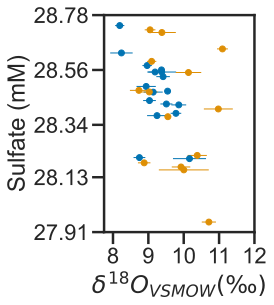

In [70]:
# Make plot
#Sort values
df_sulfate_crossplot = df_sulfate_crossplot.sort_values('real_conc')
# Group data by core
df_grouped = df_sulfate_crossplot.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(df_grouped):
    # Get Unique core labels
    color_labels = sort(df_sulfate_crossplot['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    
    #Make errorbar plot
    ax.errorbar(data['d18O'], data['real_conc'], xerr=data['d18O_sd'], fmt ='.', elinewidth=1)
    
    #Create a Savitzky-Golay filter. It uses least squares to regress a small window of your data onto a polynomial, 
    #then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward 
    #by one data point and the process repeats. This continues until every point has been optimally adjusted relative 
    #to its neighbors. It works great even with noisy samples from non-periodic and non-linear sources.
    #xhat = savgol_filter(data['d18O'], 9, 2, mode='interp') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    #ax.plot(xhat, data['real_conc'], color=colors[i])

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('$\delta^{18}O_{VSMOW} (‰)$')
    ax.set_ylabel('Sulfate (mM)')
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(0))
    ax.set_yticks(np.linspace((ax.get_ybound()[0]), (ax.get_ybound()[1]), 5).round(2))
    #ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/crossplot_o_isotopes_sulfate.pdf', bbox_inches='tight')

### 1/Sulfate

In [75]:
#Create new simplified dataframe for sulfate
#Make empty dataframe
df_sulfate_inv=pd.DataFrame()
#Fill out dataframe
# Fill master table
df_sulfate_inv['ID'] = df_sulfate_cores['ID']
df_sulfate_inv['Real_depth_cm'] = df_sulfate_cores['Real_depth_cm']
df_sulfate_inv['Core'] = df_sulfate_cores['Core']
df_sulfate_inv['real_conc'] = 1/df_sulfate_cores['real_conc']
df_sulfate_inv = df_sulfate_inv.sort_values('Real_depth_cm')
df_sulfate_inv.head()

,ID,Real_depth_cm,Core,real_conc
580,42,6.5,GC02,0.035186
611,a,11.0,GC04,0.035082
612,b,16.0,GC04,0.035115
581,40,18.5,GC02,0.035118
613,c,21.0,GC04,0.035066


In [76]:
#Fuse dataframes
df_sulfateinv_crossplot=df_sulfate_inv.merge(df_oxygen, how='left',
                 left_on=['ID'] , right_on=['ID'] ) 
#Remove rows with empty values for d18O
df_sulfateinv_crossplot = df_sulfateinv_crossplot[df_sulfateinv_crossplot['d18O'].notna()]
#Remove unnecessary columns
df_sulfateinv_crossplot = df_sulfateinv_crossplot.drop(columns=['Core_y', 'Real_depth_cm_y','Measurement'])
#Rename columns
df_sulfateinv_crossplot = df_sulfateinv_crossplot.rename(columns={"Real_depth_cm_x": "Real_depth_cm", "Core_x": "Core"})
#Show dataframe
df_sulfateinv_crossplot.head()

,ID,Real_depth_cm,Core,real_conc,Depth,d18O,d18O_sd
0,42,6.5,GC02,0.035186,123.0,9.860000,0.210000
3,40,18.5,GC02,0.035118,102.0,9.543664,0.081935
10,25,33.5,GC02,0.035047,72.0,9.417036,0.191728
11,60,36.0,GC04,0.035027,120.0,10.134174,0.361005
12,32,36.5,GC02,0.035024,81.0,9.378125,0.407844


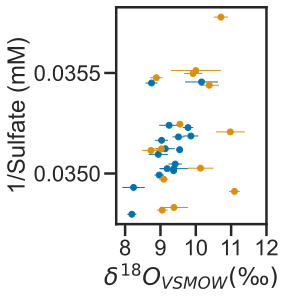

In [87]:
# Make plot
#Sort values
df_sulfateinv_crossplot = df_sulfateinv_crossplot.sort_values('real_conc')
# Group data by core
df_grouped = df_sulfateinv_crossplot.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(df_grouped):
    # Get Unique core labels
    color_labels = sort(df_sulfateinv_crossplot['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    
    #Make errorbar plot
    ax.errorbar(data['d18O'], data['real_conc'], xerr=data['d18O_sd'], fmt ='.', elinewidth=1)
    
    #Create a Savitzky-Golay filter. It uses least squares to regress a small window of your data onto a polynomial, 
    #then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward 
    #by one data point and the process repeats. This continues until every point has been optimally adjusted relative 
    #to its neighbors. It works great even with noisy samples from non-periodic and non-linear sources.
    #xhat = savgol_filter(data['d18O'], 9, 2, mode='interp') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    #ax.plot(xhat, data['real_conc'], color=colors[i])

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('$\delta^{18}O_{VSMOW} (‰)$')
    ax.set_ylabel('1/Sulfate (mM)')
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(0))
    #ax.set_yticks(np.linspace((ax.get_ybound()[0]), (ax.get_ybound()[1]), 5).round(2))
    #ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/crossplot_o_isotopes_invsulfate.pdf', bbox_inches='tight')

### Reduced sulfur

In [45]:
#Let's start by importing the file with the data
df_reduceds = pd.read_csv(f'{homedir}/data/raw/quantifications/S_intermediates.csv')
#Fill nan with 0
df_reduceds = df_reduceds.sort_values('Real_depth_cm')
df_reduceds.head()

,ID,Compound,Conc_nM,Core,Depth_cm,Real_depth_cm
106,3,Sulfite,0.000000,MC01,3,3.0
228,3,Thiosulfate,4.236321,MC01,3,3.0
347,3,Sulfide,0.000000,MC01,3,3.0
229,4,Thiosulfate,9.074780,MC01,4,4.0
107,4,Sulfite,0.000000,MC01,4,4.0


#### Sulfide

In [46]:
#Filter by sulfide
df_sulfide = df_reduceds[(df_reduceds.Compound == 'Sulfide')]
#Filter by cores 
df_sulfide_cores = df_sulfide[(df_sulfide.Core != 'MC01') & (df_sulfide.Core != 'GC06')]
df_sulfide_cores.head()

,ID,Compound,Conc_nM,Core,Depth_cm,Real_depth_cm
241,42,Sulfide,0.000000,GC02,3,6.5
277,a,Sulfide,11.497260,GC04,5,11.0
242,43,Sulfide,0.000000,GC02,12,15.5
278,b,Sulfide,24.202079,GC04,10,16.0
243,40,Sulfide,10.894785,GC02,15,18.5


In [50]:
#Fuse dataframes
df_sulfide_crossplot=df_sulfide_cores.merge(df_oxygen, how='left',
                 left_on=['ID'] , right_on=['ID'] ) 
#Remove rows with empty values for d18O
df_sulfide_crossplot = df_sulfide_crossplot[df_sulfide_crossplot['d18O'].notna()]
#Remove unnecessary columns
df_sulfide_crossplot = df_sulfide_crossplot.drop(columns=['Core_y', 'Real_depth_cm_y', 'Measurement'])
#Rename columns
df_sulfide_crossplot = df_sulfide_crossplot.rename(columns={"Real_depth_cm_x": "Real_depth_cm", "Core_x": "Core"})
#Show dataframe
df_sulfide_crossplot.head()

,ID,Compound,Conc_nM,Core,Depth_cm,Real_depth_cm,Depth,d18O,d18O_sd
0,42,Sulfide,0.000000,GC02,3,6.5,123.0,9.860000,0.210000
4,40,Sulfide,10.894785,GC02,15,18.5,102.0,9.543664,0.081935
9,33,Sulfide,23.624717,GC02,24,27.5,51.0,9.215989,0.043995
12,25,Sulfide,55.075089,GC02,30,33.5,72.0,9.417036,0.191728
13,60,Sulfide,76.841311,GC04,30,36.0,120.0,10.134174,0.361005


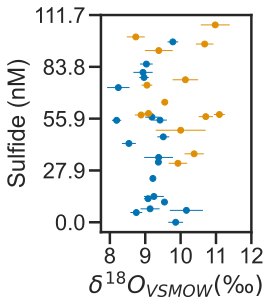

In [66]:
# Make plot
# Group data by core
df_grouped = df_sulfide_crossplot.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(df_grouped):
    # Get Unique core labels
    color_labels = sort(df_sulfide_crossplot['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    
    #Make errorbar plot
    ax.errorbar(data['d18O'], data['Conc_nM'], xerr=data['d18O_sd'], fmt ='.', elinewidth=1)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('$\delta^{18}O_{VSMOW} (‰)$')
    ax.set_ylabel('Sulfide (nM)')
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(0))
    ax.set_yticks(np.linspace(0, (ax.get_ybound()[1]), 5).round(2))
    #ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/crossplot_o_isotopes_sulfide.pdf', bbox_inches='tight')

#### Sulfite

In [67]:
#Filter by sulfite
df_sulfite = df_reduceds[(df_reduceds.Compound == 'Sulfite')]
#Filter by cores 
df_sulfite_cores = df_sulfite[(df_sulfite.Core != 'MC01') & (df_sulfite.Core != 'GC06')]
df_sulfite_cores.head()

,ID,Compound,Conc_nM,Core,Depth_cm,Real_depth_cm
0,42,Sulfite,14.524811,GC02,3,6.5
36,a,Sulfite,37.517374,GC04,5,11.0
1,43,Sulfite,16.338317,GC02,12,15.5
37,b,Sulfite,24.807131,GC04,10,16.0
2,40,Sulfite,21.184303,GC02,15,18.5


In [68]:
#Fuse dataframes
df_sulfite_crossplot=df_sulfite_cores.merge(df_oxygen, how='left',
                 left_on=['ID'] , right_on=['ID'] ) 
#Remove rows with empty values for d18O
df_sulfite_crossplot = df_sulfite_crossplot[df_sulfite_crossplot['d18O'].notna()]
#Remove unnecessary columns
df_sulfite_crossplot = df_sulfite_crossplot.drop(columns=['Core_y', 'Real_depth_cm_y', 'Measurement'])
#Rename columns
df_sulfite_crossplot = df_sulfite_crossplot.rename(columns={"Real_depth_cm_x": "Real_depth_cm", "Core_x": "Core"})
#Show dataframe
df_sulfite_crossplot.head()

,ID,Compound,Conc_nM,Core,Depth_cm,Real_depth_cm,Depth,d18O,d18O_sd
0,42,Sulfite,14.524811,GC02,3,6.5,123.0,9.860000,0.210000
4,40,Sulfite,21.184303,GC02,15,18.5,102.0,9.543664,0.081935
9,33,Sulfite,21.748300,GC02,24,27.5,51.0,9.215989,0.043995
12,25,Sulfite,32.076700,GC02,30,33.5,72.0,9.417036,0.191728
13,60,Sulfite,58.400000,GC04,30,36.0,120.0,10.134174,0.361005


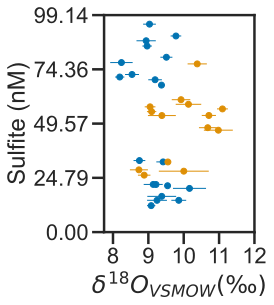

In [69]:
# Make plot
# Group data by core
df_grouped = df_sulfite_crossplot.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(df_grouped):
    # Get Unique core labels
    color_labels = sort(df_sulfite_crossplot['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    
    #Make errorbar plot
    ax.errorbar(data['d18O'], data['Conc_nM'], xerr=data['d18O_sd'], fmt ='.', elinewidth=1)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('$\delta^{18}O_{VSMOW} (‰)$')
    ax.set_ylabel('Sulfite (nM)')
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(0))
    ax.set_yticks(np.linspace(0, (ax.get_ybound()[1]), 5).round(2))
    #ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/crossplot_o_isotopes_sulfite.pdf', bbox_inches='tight')

#### Thiosulfate

In [71]:
#Filter by sulfide
df_thiosulfate = df_reduceds[(df_reduceds.Compound == 'Thiosulfate')]
#Filter by cores 
df_thiosulfate_cores = df_thiosulfate[(df_thiosulfate.Core != 'MC01') & (df_thiosulfate.Core != 'GC06')]
df_thiosulfate_cores.head()

,ID,Compound,Conc_nM,Core,Depth_cm,Real_depth_cm
119,42,Thiosulfate,6.052004,GC02,3,6.5
155,a,Thiosulfate,0.000000,GC04,5,11.0
120,43,Thiosulfate,5.446106,GC02,12,15.5
156,b,Thiosulfate,1.815156,GC04,10,16.0
121,40,Thiosulfate,2.421063,GC02,15,18.5


In [72]:
#Fuse dataframes
df_thiosulfate_crossplot=df_thiosulfate_cores.merge(df_oxygen, how='left',
                 left_on=['ID'] , right_on=['ID'] ) 
#Remove rows with empty values for d18O
df_thiosulfate_crossplot = df_thiosulfate_crossplot[df_thiosulfate_crossplot['d18O'].notna()]
#Remove unnecessary columns
df_thiosulfate_crossplot = df_thiosulfate_crossplot.drop(columns=['Core_y', 'Real_depth_cm_y', 'Measurement'])
#Rename columns
df_thiosulfate_crossplot = df_thiosulfate_crossplot.rename(columns={"Real_depth_cm_x": "Real_depth_cm", "Core_x": "Core"})
#Show dataframe
df_thiosulfate_crossplot.head()

,ID,Compound,Conc_nM,Core,Depth_cm,Real_depth_cm,Depth,d18O,d18O_sd
0,42,Thiosulfate,6.052004,GC02,3,6.5,123.0,9.860000,0.210000
4,40,Thiosulfate,2.421063,GC02,15,18.5,102.0,9.543664,0.081935
9,33,Thiosulfate,10.874150,GC02,24,27.5,51.0,9.215989,0.043995
12,25,Thiosulfate,10.893974,GC02,30,33.5,72.0,9.417036,0.191728
13,60,Thiosulfate,23.601389,GC04,30,36.0,120.0,10.134174,0.361005


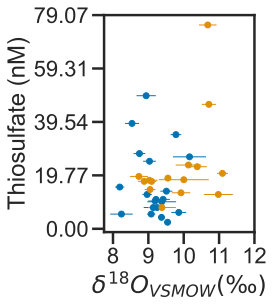

In [73]:
# Make plot
# Group data by core
df_grouped = df_thiosulfate_crossplot.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for i, (group,data) in enumerate(df_grouped):
    # Get Unique core labels
    color_labels = sort(df_thiosulfate_crossplot['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data['Core'].map(color_map)
    
    #Make errorbar plot
    ax.errorbar(data['d18O'], data['Conc_nM'], xerr=data['d18O_sd'], fmt ='.', elinewidth=1)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('$\delta^{18}O_{VSMOW} (‰)$')
    ax.set_ylabel('Thiosulfate (nM)')
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(0))
    ax.set_yticks(np.linspace(0, (ax.get_ybound()[1]), 5).round(2))
    #ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/crossplot_o_isotopes_thiosulfate.pdf', bbox_inches='tight')